#### Import libraries and packages

In [2]:
import pandas as pd
import geopandas as gpd
import rasterio as rio
import shapely
import ee, geemap, eemont
import json

In [3]:
ee.Authenticate()
ee.Initialize()

#### Load satellite dataset and fire preimeter

Copernicus Sentinel-2 (COPERNICUS/S2_SR_HARMONIZED) data involves using the surface reflectance information in the data to calculate spectral indices like the Normalized Burn Ratio (NBR) or specialized indices like BADI, or employing machine learning algorithms with spectral and textural features to distinguish burned areas from other land cover changes.



data source: https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all/explore?location=37.187645%2C-120.227660%2C5.95

tutorials: https://www.un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/burn-severity-earth-engine

In [4]:
in_file = f"../data/California_Historic_Fire_Perimeters.geojson"

In [5]:
fire_gdf = gpd.read_file(in_file)
fire_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22810 entries, 0 to 22809
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      22810 non-null  int32   
 1   YEAR_         22733 non-null  float64 
 2   STATE         22810 non-null  object  
 3   AGENCY        22761 non-null  object  
 4   UNIT_ID       22749 non-null  object  
 5   FIRE_NAME     22748 non-null  object  
 6   INC_NUM       21839 non-null  object  
 7   ALARM_DATE    17414 non-null  object  
 8   CONT_DATE     10180 non-null  object  
 9   CAUSE         22810 non-null  int32   
 10  C_METHOD      10708 non-null  float64 
 11  OBJECTIVE     22539 non-null  float64 
 12  GIS_ACRES     22810 non-null  float64 
 13  COMMENTS      2835 non-null   object  
 14  COMPLEX_NAME  611 non-null    object  
 15  IRWINID       3736 non-null   object  
 16  FIRE_NUM      17642 non-null  object  
 17  COMPLEX_ID    567 non-null    object  
 18

In [ ]:
fire_gdf.head(5)

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry
0,1,2025.0,CA,CDF,LDF,PALISADES,00000738,"Tue, 07 Jan 2025 08:00:00 GMT","Fri, 31 Jan 2025 08:00:00 GMT",14,7.0,1.0,23448.8800,None,None,{A7EA5D21-F882-44B8-BF64-44AB11059DC1},None,None,2020-January 2025,"MULTIPOLYGON (((-118.51975 34.02997, -118.5198..."
1,2,2025.0,CA,CDF,LAC,EATON,00009087,"Wed, 08 Jan 2025 08:00:00 GMT","Fri, 31 Jan 2025 08:00:00 GMT",14,7.0,1.0,14056.2600,None,None,{72660ADC-B5EF-4D96-A33F-B4EA3740A4E3},None,None,2020-January 2025,"MULTIPOLYGON (((-118.10094 34.16681, -118.1009..."
2,3,2025.0,CA,CDF,ANF,HUGHES,00250270,"Wed, 22 Jan 2025 08:00:00 GMT","Tue, 28 Jan 2025 08:00:00 GMT",14,7.0,1.0,10396.8000,None,None,{994072D2-E154-434A-BB95-6F6C94C40829},None,None,2020-January 2025,"MULTIPOLYGON (((-118.55862 34.58099, -118.5585..."
3,4,2025.0,CA,CCO,VNC,KENNETH,00003155,"Thu, 09 Jan 2025 08:00:00 GMT","Tue, 04 Feb 2025 08:00:00 GMT",14,2.0,1.0,998.7378,from OES Intel 24,None,{842FB37B-7AC8-4700-BB9C-028BF753D149},None,None,2020-January 2025,"POLYGON ((-118.67692 34.16894, -118.6769 34.16..."
4,5,2025.0,CA,CDF,LDF,HURST,00003294,"Tue, 07 Jan 2025 08:00:00 GMT","Thu, 09 Jan 2025 08:00:00 GMT",14,7.0,1.0,831.3855,None,None,{F4E810AD-CDF3-4ED4-B63F-03D43785BA7B},None,None,2020-January 2025,"POLYGON ((-118.46974 34.33079, -118.46964 34.3..."


The dataset includes the year of fires, the occurance place, fire name, alarm and containment date



We chose the fires that occured during 2024-2025, perform statistical analysis to find the time window within each year

Prepare the ground truth for fire area detection on the satellite imagery, by comparing the pre and post fire (before the time window and after the window)

2020
2021
2022
2023
2024
2025

In [6]:
fire_df = pd.DataFrame(fire_gdf)
fire_df["ALARM_DATE_ISO"] = pd.to_datetime(fire_df.ALARM_DATE, format='%a, %d %b %Y %H:%M:%S %Z').dt.tz_convert('UTC').dt.strftime('%Y-%m-%dT%H:%M:%SZ')
fire_df["CONT_DATE_ISO"]  = pd.to_datetime(fire_df.CONT_DATE, format='%a, %d %b %Y %H:%M:%S %Z').dt.tz_convert('UTC').dt.strftime('%Y-%m-%dT%H:%M:%SZ')

In [7]:
fire_df.head(5)

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,...,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry,ALARM_DATE_ISO,CONT_DATE_ISO
0,1,2025.0,CA,CDF,LDF,PALISADES,00000738,"Tue, 07 Jan 2025 08:00:00 GMT","Fri, 31 Jan 2025 08:00:00 GMT",14,...,23448.8800,None,None,{A7EA5D21-F882-44B8-BF64-44AB11059DC1},None,None,2020-January 2025,"MULTIPOLYGON (((-118.51975 34.02997, -118.5198...",2025-01-07T08:00:00Z,2025-01-31T08:00:00Z
1,2,2025.0,CA,CDF,LAC,EATON,00009087,"Wed, 08 Jan 2025 08:00:00 GMT","Fri, 31 Jan 2025 08:00:00 GMT",14,...,14056.2600,None,None,{72660ADC-B5EF-4D96-A33F-B4EA3740A4E3},None,None,2020-January 2025,"MULTIPOLYGON (((-118.10094 34.16681, -118.1009...",2025-01-08T08:00:00Z,2025-01-31T08:00:00Z
2,3,2025.0,CA,CDF,ANF,HUGHES,00250270,"Wed, 22 Jan 2025 08:00:00 GMT","Tue, 28 Jan 2025 08:00:00 GMT",14,...,10396.8000,None,None,{994072D2-E154-434A-BB95-6F6C94C40829},None,None,2020-January 2025,"MULTIPOLYGON (((-118.55862 34.58099, -118.5585...",2025-01-22T08:00:00Z,2025-01-28T08:00:00Z
3,4,2025.0,CA,CCO,VNC,KENNETH,00003155,"Thu, 09 Jan 2025 08:00:00 GMT","Tue, 04 Feb 2025 08:00:00 GMT",14,...,998.7378,from OES Intel 24,None,{842FB37B-7AC8-4700-BB9C-028BF753D149},None,None,2020-January 2025,"POLYGON ((-118.67692 34.16894, -118.6769 34.16...",2025-01-09T08:00:00Z,2025-02-04T08:00:00Z
4,5,2025.0,CA,CDF,LDF,HURST,00003294,"Tue, 07 Jan 2025 08:00:00 GMT","Thu, 09 Jan 2025 08:00:00 GMT",14,...,831.3855,None,None,{F4E810AD-CDF3-4ED4-B63F-03D43785BA7B},None,None,2020-January 2025,"POLYGON ((-118.46974 34.33079, -118.46964 34.3...",2025-01-07T08:00:00Z,2025-01-09T08:00:00Z


<AxesSubplot: >

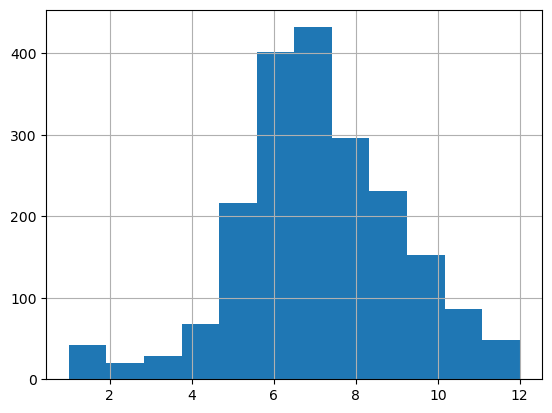

In [ ]:
fire_df.query("DECADES == '2020-January 2025'").CONT_DATE_NEW.dt.month.hist(bins=12)

<AxesSubplot: >

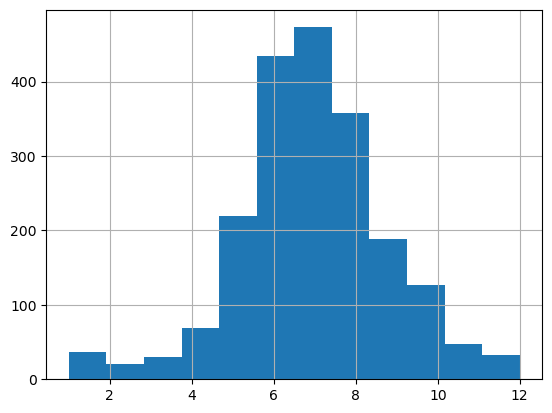

In [ ]:
fire_df.query("DECADES == '2020-January 2025'").ALARM_DATE_NEW.dt.month.hist(bins=12)

#### Select study area, time frame and create cloud mask

In [ ]:
fire_gdf.DECADES.unique()

array(['2020-January 2025', '2010-2019', '2000-2009', '1990-1999',
       '1980-1989', '1970-1979', '1960-1969', '1950-1959', None],
      dtype=object)

### Filter recently five years

In [8]:
aoi = fire_gdf[fire_gdf.DECADES == "2020-January 2025"]

In [9]:
aoi = gpd.GeoDataFrame(aoi)

In [ ]:
aoi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2036 entries, 0 to 2035
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      2036 non-null   int32   
 1   YEAR_         2036 non-null   float64 
 2   STATE         2036 non-null   object  
 3   AGENCY        2036 non-null   object  
 4   UNIT_ID       2035 non-null   object  
 5   FIRE_NAME     2036 non-null   object  
 6   INC_NUM       2031 non-null   object  
 7   ALARM_DATE    2036 non-null   object  
 8   CONT_DATE     2022 non-null   object  
 9   CAUSE         2036 non-null   int32   
 10  C_METHOD      2036 non-null   float64 
 11  OBJECTIVE     2003 non-null   float64 
 12  GIS_ACRES     2036 non-null   float64 
 13  COMMENTS      409 non-null    object  
 14  COMPLEX_NAME  59 non-null     object  
 15  IRWINID       1901 non-null   object  
 16  FIRE_NUM      0 non-null      object  
 17  COMPLEX_ID    55 non-null     object  
 18  DECAD

In [10]:
geojson = json.loads(aoi.to_json())

<Axes: >

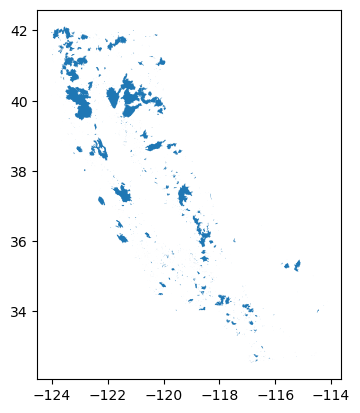

In [11]:
aoi.geometry.plot()   ## 2020-2025

#### Analysis based on major fire events

In [7]:
major_fires = fire_df[
    (fire_df.GIS_ACRES > 10000) &
    (fire_df.DECADES == "2020-January 2025") &
    (fire_df.YEAR_ > 2020.0)
    ].sort_values('GIS_ACRES', ascending=False)

In [8]:
top_fires = major_fires.head(10)

In [ ]:
analysis_regions = []
for idx, fire in top_fires.iterrows():
    fire_geom = fire.geometry
    buffered_geom = fire_geom.buffer(0.01)  # ~5km buffer around fire
    analysis_regions.append({
        'name': fire.FIRE_NAME,
        'geometry': buffered_geom,
        'alarm_date': fire.ALARM_DATE_ISO,
        'containment_date': fire.CONT_DATE_ISO
    })

In [45]:
analysis_regions[0]

{'name': 'DIXIE',
 'geometry': <POLYGON ((-121.467 40.004, -121.469 40.003, -121.47 40.002, -121.471 40.002...>,
 'alarm_date': '2021-07-14T07:00:00Z',
 'containment_date': '2021-10-25T07:00:00Z'}

In [40]:
region = analysis_regions[0]
region_gdf = gpd.GeoDataFrame([region], geometry='geometry', crs='EPSG:4326')
region_ee = geemap.geopandas_to_ee(region_gdf)
region_geom = region_ee.geometry()
print(f"Processing region: {region['name']}")

Processing region: DIXIE


In [41]:
CLOUD_THRESHOLD = 20
PRE_FIRE_DAYS = 30  # Days before fire to include
POST_FIRE_DAYS = 60  # Days after containment to include

In [42]:
# Calculate time window for imagery using ISO
pre_fire_start = ee.Date(region['alarm_date']).advance(-PRE_FIRE_DAYS, 'day')
post_fire_end = ee.Date(region['containment_date']).advance(POST_FIRE_DAYS, 'day')

In [59]:
# Get Sentinel-2 collection for this region and time period
collection = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(region_geom)
    .filterDate(pre_fire_start, post_fire_end)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_THRESHOLD))
    .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])
)

In [53]:
# Create pre-fire and post-fire composites
pre_fire_img = collection.filterDate(pre_fire_start, ee.Date(region['alarm_date'])).median().clip(region_geom)
post_fire_img = collection.filterDate(ee.Date(region['containment_date']), post_fire_end).median().clip(region_geom)

In [54]:
# Create fire mask - need to get the original fire geometry
# First get the original fire geometry (without buffer)
original_fire_gdf = fire_gdf[fire_gdf.FIRE_NAME == region['name']].iloc[0:1]
original_fire_fc = geemap.geopandas_to_ee(original_fire_gdf)
original_fire_geom = original_fire_fc.geometry()

In [55]:
fire_mask = ee.Image(0).byte().paint(original_fire_fc, 1).rename("mask").clip(region_geom)

In [56]:
# Calculate NBR
pre_fire_nbr = pre_fire_img.normalizedDifference(['B8', 'B12']).rename('NBR')
post_fire_nbr = post_fire_img.normalizedDifference(['B8', 'B12']).rename('NBR')
dnbr = pre_fire_nbr.subtract(post_fire_nbr).rename('dNBR')

In [57]:
result_img = ee.Image.cat([
        pre_fire_img.select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12']),
        post_fire_img.select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12']),
        pre_fire_nbr,
        post_fire_nbr,
        dnbr,
        fire_mask
    ])

In [60]:
# Combine all bands into separate images for smaller exports
clean_name = region['name'].replace(' ', '_').replace('/', '_')
alarm_date_short = region['alarm_date'][:10].replace('-', '')

# Export 1: Pre-fire image (only visual bands)
pre_fire_visual = pre_fire_img.select(['B2', 'B3', 'B4'])  # RGB only
task1 = ee.batch.Export.image.toDrive(
    image=pre_fire_visual,
    description=f'pre_fire_{clean_name}_{alarm_date_short}',
    folder='fire_events',
    scale=20,
    region=region_geom,
    maxPixels=1e10,
    fileFormat='GeoTIFF'
)
task1.start()

# Export 2: Post-fire image (only visual bands)
post_fire_visual = post_fire_img.select(['B2', 'B3', 'B4'])  # RGB only
task2 = ee.batch.Export.image.toDrive(
    image=post_fire_visual,
    description=f'post_fire_{clean_name}_{alarm_date_short}',
    folder='fire_events',
    scale=20,
    region=region_geom,
    maxPixels=1e10,
    fileFormat='GeoTIFF'
)
task2.start()

# Export 3: Spectral indices and mask (smaller file)
indices_mask = ee.Image.cat([pre_fire_nbr, post_fire_nbr, dnbr, fire_mask])
task3 = ee.batch.Export.image.toDrive(
    image=indices_mask,
    description=f'indices_{clean_name}_{alarm_date_short}',
    folder='fire_events',
    scale=20,
    region=region_geom,
    maxPixels=1e10,
    fileFormat='GeoTIFF'
)
task3.start()

In [71]:
# Create an interactive map
Map = geemap.Map()
Map.add_basemap('SATELLITE')  # Add satellite basemap

# Pre-fire natural color (RGB)
pre_fire_rgb = pre_fire_img.select(['B4', 'B3', 'B2'])  # RGB bands
Map.addLayer(pre_fire_rgb, {'min': 0, 'max': 3000}, 'Pre-fire RGB')

# Post-fire natural color (RGB)
post_fire_rgb = post_fire_img.select(['B4', 'B3', 'B2'])  # RGB bands
Map.addLayer(post_fire_rgb, {'min': 0, 'max': 3000}, 'Post-fire RGB')

# Pre-fire false color (for vegetation)
pre_fire_false_color = pre_fire_img.select(['B8', 'B4', 'B3'])  # NIR, Red, Green
Map.addLayer(pre_fire_false_color, {'min': 0, 'max': 3000}, 'Pre-fire False Color')

# Post-fire false color
post_fire_false_color = post_fire_img.select(['B8', 'B4', 'B3'])  # NIR, Red, Green
Map.addLayer(post_fire_false_color, {'min': 0, 'max': 3000}, 'Post-fire False Color')

# NBR difference (dNBR) - fire severity
dnbr_vis = {
    'min': -1, 
    'max': 1,
    'palette': ['blue', 'green', 'yellow', 'red']  # Blue (unburned) to Red (severely burned)
}
Map.addLayer(dnbr, dnbr_vis, 'dNBR Fire Severity')

# Fire mask
fire_mask_vis = {
    'min': 0,
    'max': 1,
    'palette': ['00000000', 'FF0000']  # Transparent, Red
}
Map.addLayer(fire_mask, fire_mask_vis, 'Fire Mask')
Map.centerObject(region_geom, 10)
Map


Map(center=[40.21378330713899, -121.00376980791079], controls=(WidgetControl(options=['position', 'transparent…

#### Query ad filter image collections

In [ ]:
CLOUD_THRESHOLD = 10

In [14]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

In [15]:
START_DATE = "2024-01-01"
END_DATE = "2025-09-01"
start = ee.Date(START_DATE)
end = ee.Date(END_DATE)

In [30]:
perims = geemap.geopandas_to_ee(aoi)

In [32]:
perims = perims.filter(ee.Filter.And(
    ee.Filter.gte('CONT_DATE_ISO', START_DATE),
    ee.Filter.lte('CONT_DATE_ISO', END_DATE)
))

In [20]:
AOI = ee.Geometry.BBoxFromQuery("California, United States", user_agent = "RS_course")

In [33]:
collection = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(AOI)
    .filterDate(start, end)
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_THRESHOLD))
    .map(mask_s2_clouds)
)

In [38]:
def get_monthly_composite(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')
    
    # Filter collection for this month
    monthly_col = collection.filterDate(start, end)
    
    # Check if we have any images for this month
    count = monthly_col.size()
    has_images = count.gt(0)
    
    # Create a base image with zeros for when no data exists
    base_img = ee.Image(0).selfMask().clip(AOI)
    
    # Process if we have images
    monthly_img = ee.Algorithms.If(
        has_images,
        monthly_col.median().clip(AOI),
        base_img
    )
    
    # Convert to image (needed for ee.Algorithms.If)
    monthly_img = ee.Image(monthly_img)
    
    # Fire mask: fires contained this month
    fires_in_month = perims.filter(
        ee.Filter.And(
            ee.Filter.gte('CONT_DATE_ISO', start),
            ee.Filter.lt('CONT_DATE_ISO', end)
        )
    )
    
    # Create mask - check if any fires in this month
    has_fires = fires_in_month.size().gt(0)
    mask = ee.Algorithms.If(
        has_fires,
        ee.Image(0).byte().paint(fires_in_month, 1).rename("mask").clip(AOI),
        ee.Image(0).byte().rename("mask").clip(AOI)
    )
    mask = ee.Image(mask)
    
    # Add NBR if we have the required bands
    has_bands = monthly_img.bandNames().size().gt(0)
    nbr = ee.Algorithms.If(
        has_bands.And(has_images),
        monthly_img.normalizedDifference(['B8', 'B12']).rename('NBR'),
        ee.Image(0).rename('NBR').clip(AOI)
    )
    nbr = ee.Image(nbr)
    
    # Combine all bands
    result = ee.Image.cat([monthly_img, mask, nbr]).set({
        'year': year,
        'month': month,
        'system:time_start': start.millis(),
        'system:index': ee.String(str(year)).cat("_").cat(ee.String(str(month)))
    })
    
    return result

In [39]:
# Create list of months to process
years = list(range(2024, 2026))
months_list = []
for y in years:
    max_m = 12 if y < 2025 else 8  # Stop at August 2025
    for m in range(1, max_m + 1):
        months_list.append((y, m))

In [41]:
# Process and export each month separately to avoid payload size issues
out_dir = "../data/img/"

for year, month in months_list:
    print(f"Processing {year}-{month:02d}")
    
    # Get the monthly composite
    monthly_img = get_monthly_composite(year, month)
    
    # Define filename
    filename = f"s2_{year}_{month:02d}.tif"
    
    # Export the image
    try:
        geemap.ee_export_image(
            monthly_img,
            filename=filename,
            scale=20,
            region=AOI,
            file_per_band=False
        )
        print(f"Successfully exported {filename}")
    except Exception as e:
        print(f"Error exporting {filename}: {str(e)}")

Processing 2024-01
Generating URL ...
An error occurred while downloading.
Request payload size exceeds the limit: 10485760 bytes.
Successfully exported s2_2024_01.tif
Processing 2024-02
Generating URL ...


KeyboardInterrupt: 